In [64]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import (
    DateRange,
    Dimension,
    Filter,
    FilterExpression,
    FilterExpressionList,
    Metric,
    RunReportRequest,
)
from google.analytics.data_v1beta.types import OrderBy

In [65]:
## Set up global variables
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'ga4apikey.json'
property_id = 'GA4_property_id'
client = BetaAnalyticsDataClient()

In [66]:
def format_report(request):
    response = client.run_report(request)
    
    # Row index
    row_index_names = [header.name for header in response.dimension_headers]
    row_header = []
    for i in range(len(row_index_names)):
        row_header.append([row.dimension_values[i].value for row in response.rows])

    row_index_named = pd.MultiIndex.from_arrays(np.array(row_header), names = np.array(row_index_names))
    # Row flat data
    metric_names = [header.name for header in response.metric_headers]
    data_values = []
    for i in range(len(metric_names)):
        data_values.append([row.metric_values[i].value for row in response.rows])

    output = pd.DataFrame(data = np.transpose(np.array(data_values, dtype = 'f')), 
                          index = row_index_named, columns = metric_names)
    return output

In [67]:
request = RunReportRequest(
        property='properties/'+'294467527',
        dimensions=[
            Dimension(name="Date"),
            Dimension(name="eventName"),
            Dimension(name="customUser:client_id_ga4"),
            Dimension(name="customEvent:checkout_type")
                   ],
        metrics=[#Metric(name="totalUsers"),
                 Metric(name="eventCount")
                 ],
        date_ranges=[DateRange(start_date="2023-01-21", end_date="2023-01-21")],
        dimension_filter=FilterExpression(
            and_group=FilterExpressionList(
                expressions=[
                    FilterExpression(
                        not_expression = FilterExpression(
                            filter=Filter(
                                field_name="pagePath",
                                string_filter=Filter.StringFilter(
                                    match_type=Filter.StringFilter.MatchType.CONTAINS,
                                    value= 'blog')
                            ),
                        )
                    ),
                    FilterExpression(
                        filter=Filter(
                            field_name="deviceCategory",
                            string_filter=Filter.StringFilter(
                                match_type=Filter.StringFilter.MatchType.CONTAINS,
                                value= 'desktop'),
                        )
                    ),
                ]
            )
        )
)

In [68]:
users = format_report(request)
users.reset_index(inplace=True)
users = users[users['customUser:client_id_ga4'] != '(not set)']
users = users.pivot_table(index = 'Date', values='customUser:client_id_ga4', aggfunc=lambda x: len(x.unique()))
users = users.rename(columns={"customUser:client_id_ga4": "totalUsers"}, errors="raise")

In [69]:
data_full = format_report(request)
data_full.reset_index(inplace=True)
data = data_full.pivot_table(
    index=['Date', 'eventName', 'customEvent:checkout_type'], \
    values='customUser:client_id_ga4', aggfunc=lambda x: len(x.unique()))
data = data.join(users)

data_without_type = data_full.pivot_table(
    index=['Date', 'eventName'], \
    values='customUser:client_id_ga4', aggfunc=lambda x: len(x.unique()))
data_without_type = data_without_type.join(users)

data['rate'] = data['customUser:client_id_ga4'] / data['totalUsers'] * 100
data.reset_index(inplace=True)
data.columns = ('Date', 'event', 'type', 'users', 'total_users', 'rate')

In [70]:
users

,totalUsers
Date,
20230121,745


In [71]:
def get_plot(event, type, rate=False):
    if type == 'all':
        result = data_without_type
        result['rate'] = result['customUser:client_id_ga4'] / result['totalUsers'] * 100
        result.reset_index(inplace=True)
        result.columns = ('Date', 'event', 'users', 'total_users', 'rate')
        result = result.query(f'event == "{event}"')
        result.reset_index(inplace=True, drop=True)
        display(result)
        fig, by = plt.subplots(figsize=(15,5))
    else:
        result = data.query(f'event == "{event}"')
        result = result.query(f'type == "{type}"')
        result.reset_index(inplace=True, drop=True)
        display(result)
        fig, by = plt.subplots(figsize=(15,5))
    if rate==False:
        by = sns.lineplot(data=result, x='Date', y='users')
        return plt.show()
    elif rate==True:
        by = sns.lineplot(data=result, x='Date', y='rate')
    return plt.show()

,Date,event,type,users,total_users,rate
0,20230121,checkout,music,1,745,0.134228


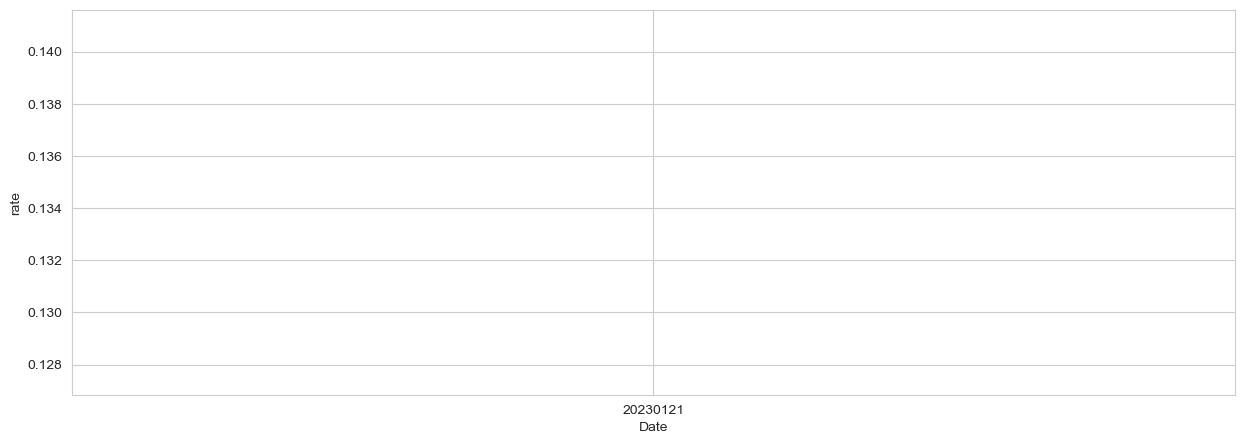

In [74]:
get_plot('checkout', 'music', rate=True)

In [73]:
data_voronka = data_full.pivot_table(index='eventName', values='customUser:client_id_ga4', aggfunc=lambda x: len(x.unique()))
data_voronka.reset_index(inplace=True)
data_voronka.columns = ('event', 'users')
data_voronka = data_voronka.sort_values(by = 'users', ascending=False)
data_voronka.reset_index(inplace=True, drop=True)
data_voronka['rate'] = data_voronka['users'] / int(data_voronka.loc[0,'users']) * 100

display(data_voronka)
print('total users =', int(users.sum()))
fig = go.Figure(go.Funnel(
    y = data_voronka.event,
    x = data_voronka.users,
    textposition = "outside",
    textinfo = "value+percent initial"))
fig.update_layout(
    autosize=False,
    width=1600,
    height=1600
    )
fig.show()

,event,users,rate
0,user_data_event,706,100.000000
1,user_engagement,603,85.410765
2,page_view,484,68.555241
3,select_item,257,36.402266
4,session_start,202,28.611898
5,scroll,145,20.538244
6,login,53,7.507082
7,view_search_results,29,4.107649
8,first_visit,15,2.124646
9,view_item,13,1.841360


total users = 745
